In [99]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import time

In [100]:
from  sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [101]:
df=pd.read_csv("output2.csv")
df.head()

,time,city,income,state,product,_id,temp,surge,weather
0,"Fri, 20 Nov 2015 22:19:52 GMT",Atlanta,High,GA,UberSUV,b605b0b06730c256bc90499b6c53afaf,62,10,Clear
1,"Sat, 28 Nov 2015 13:39:55 GMT",San Francisco,Low,CA,UberSUV,5ac25b0bb4283ddcd818a07d5e7507d5,47,10,Clear
2,"Mon, 30 Nov 2015 03:16:49 GMT",Atlanta,Low,GA,uberXL,a209e7632350d72f82aff073fc406563,69,10,Overcast
3,"Wed, 18 Nov 2015 17:54:37 GMT",Atlanta,Low,GA,UberBLACK,06acbfc4f40ff6cb6ef15a8755945079,66,10,Rain
4,"Wed, 18 Nov 2015 19:27:14 GMT",Atlanta,High,GA,UberBLACK,8a45a65827191fa1ba23fdf767196104,69,10,Rain


In [102]:
# Function to put full name of Day
def day_fix(string):
    if string == 'Mon':
        return "Monday"
    elif string =='Tue':
        return "Tuesday"
    elif string =='Wed':
        return "Wednesday"
    elif string =='Thu':
        return 'Thursday'
    elif string == 'Fri':
        return 'Friday'
    elif string == 'Sat':
        return 'Saturday'
    elif string == 'Sun':
        return 'Sunday'
    else:
        print "Error in day_fix!!!!!"

# Function to round everything **Down** to the nearest 10 minutes
def min_fix(string):
    num = int(string)
    return str(num - (num%10))

# Check and replace the surge
def surge_check(surge):
    if surge == 10:
        return "No Surge"
    elif surge > 15:
        return "High Surge"
    elif surge == 15:
        return "Mid Surge"
    else:
        return "Low Surge"

After messing with the data, found that only a small percentage of the data has a Surge (only 5.6%). After digging deeper into the surge prices and messing around with different combinations I set the limits at **Low Surge < 1.5x**, **Mid Surge = 1.5x**, and **High Surge > 1.5x**. I thought that is a fair cut off as well because you are spending 50% more on the ride at 1.5x surge.

The first function is just to correct the days from their shortened version into full length versions (e.g. "Mon" -> "Monday")

In [103]:
#Code to clean cartype
for index in df.index:
    if df.loc[index,'product'] == 'uberX + Car Seat':
        df.loc[index,'product'] = 'uberX'
    elif df.loc[index,'product'] == 'SUV + Car Seat':
        df.loc[index,'product'] = 'UberSUV'
    elif df.loc[index,'product'] == 'BLACK CAR + Car Seat':
        df.loc[index,'product'] = 'UberBlack'
    elif df.loc[index,'product'] == 'UberSELECT':
        df.loc[index,'product'] = 'uberSELECT'
    elif df.loc[index,'product'] == 'uberT':
        df.loc[index,'product'] = 'uberTAXI'
    elif df.loc[index,'product'] == 'UberBLACK':
        df.loc[index,'product'] = 'UberBlack'
    

In [104]:
# Remove the extra rows from the dataframe
remove = ['uberWAV', 'WAV', 'uberFAMILY', 'ASSIST', 'Yellow WAV']
remove_mask = [i not in remove for i in df['product']]
df =df[remove_mask]
df.reset_index(inplace=True, drop = True)

The above is to clean the car type column. I write it to only leave UberSUV, UberBlack, uberX, uberXL, uberTAXI, uberSELECT. For some of this this is taking out the change in spellings (e.g. 'UberBlack' and 'UberBLACK' to just 'UberBlack'). Others is taking out the extra car seat added. Then I also got rid of all the WAV cars (sorry handicap people, really apologize).

In [105]:
# Code to extract Weekdays and time of day from given dataframe
time_list = [df.time[index].split(' ') for index in df.index]
weekday_list = []
hour_list = []
for row in range(len(time_list)):
    
    #Cleaning the time column from the queried data set
    time_list[row].remove('GMT')
    time_list[row][0] = time_list[row][0].replace(',','')
    time_list[row][0] = day_fix(time_list[row][0])
    hour = int(time_list[row][4][0:2])
    
    # fix the time change
    if df.loc[row,'city'] == 'San Francisco':
        hour = hour - 8
    else: 
        hour = hour - 5
    if hour < 0 :
        hour = 24 + hour
    
    # Append the Weekday to a list to be put into the dataframe
    weekday_list.append(time_list[row][0])
    
    # call the min_fix function above and create the hours in 10 minute intervals
    hour_list.append( str(hour) + ':' + min_fix(time_list[row][4][3:5]) )

In [106]:
#Code to convert Temp to ints
temperature_list = [int(df.temp[index]) for index in df.index]

In [107]:
#Code to create Surge levels
surge_list = [surge_check(df.surge[index]) for index in df.index]

In [108]:
# Cleaning the Weather Column
for row in range(len(df)):
    if df.loc[row,'weather'] == 'Light Rain':
        df.loc[row,'weather'] = 'Rain'
    elif df.loc[row,'weather'] == 'Scattered Clouds':
        df.loc[row,'weather'] = 'Cloudy'
    elif df.loc[row,'weather'] == 'Mostly Cloudy':
        df.loc[row,'weather'] = 'Cloudy'
    elif df.loc[row,'weather'] == 'Partly Cloudy':
        df.loc[row,'weather'] = 'Cloudy'
    elif df.loc[row,'weather'] == 'Overcast':
        df.loc[row,'weather'] = 'Clear'

Cleaning for the Weather Column to consolidate the columns into better categories that are more compact.

In [109]:
# Create Final Dataframe for use
dict_final = {}
dict_final = {'id': df._id, 'surge': surge_list , 'temperature': temperature_list, 'weather': df.weather,
             'cartype': df['product'], 'city': df.city, 'income': df.income, 'weekday': weekday_list, 
              'time': hour_list}
df_final = pd.DataFrame(dict_final)
df_final.reset_index(inplace=True, drop = True)
df_final.head()

,cartype,city,id,income,surge,temperature,time,weather,weekday
0,UberSUV,Atlanta,b605b0b06730c256bc90499b6c53afaf,High,No Surge,62,17:10,Clear,Friday
1,UberSUV,San Francisco,5ac25b0bb4283ddcd818a07d5e7507d5,Low,No Surge,47,5:30,Clear,Saturday
2,uberXL,Atlanta,a209e7632350d72f82aff073fc406563,Low,No Surge,69,22:10,Clear,Monday
3,UberBlack,Atlanta,06acbfc4f40ff6cb6ef15a8755945079,Low,No Surge,66,12:50,Rain,Wednesday
4,UberBlack,Atlanta,8a45a65827191fa1ba23fdf767196104,High,No Surge,69,14:20,Rain,Wednesday


In [110]:
# Code to test No Surge vs Low Surge vs. High Surge

count_nosurge = df['surge'] == 10
count_surge = df['surge'] != 10
surgedf = df[count_surge]

count_highsurge = df['surge'] > 15
count_lowsurge = surgedf['surge'] < 15
count_midsurge = surgedf['surge'] == 15

print 'Percentage of data that has surge %0.3f' % (float(sum(count_surge))/len(df_final))
print 'Percentage of Surge that has Low Surge %0.3f' % (float(sum(count_lowsurge))/sum(count_surge))
print 'Percentage of Surge that has High Surge %0.3f' % ((float(sum(count_highsurge))/sum(count_surge)))
print 'Percentage of Surge that has Mid Surge %0.3f' % (float(sum(count_midsurge))/sum(count_surge))


Percentage of data that has surge 0.040
Percentage of Surge that has Low Surge 0.338
Percentage of Surge that has High Surge 0.338
Percentage of Surge that has Mid Surge 0.324


The above was just to see the relative size of the categories, as you can see I wanted to balance the categories and only found a small amount that actually have a surge. Should be mentioned in the write up.

In [111]:
# split into training and test data
itrain, itest = train_test_split(xrange(df_final.shape[0]), train_size=0.7)

mask=np.ones(df_final.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

#split training set into validation set if needed (not ended up needed)
itrain, itest = train_test_split(xrange(df_final[mask].shape[0]), train_size=0.7)

mask2 = np.ones(df_final[mask].shape[0], dtype = 'int')
mask2[itrain] = 1
mask2[itest] = 0
mask2 = (mask2==1)


In [112]:
#Check data cleaning
print df_final['weather'].unique()
print df_final['cartype'].unique()
print df_final['city'].unique()
print len(df_final['time'].unique())
print type(df_final['temperature'][0])

['Clear' 'Rain' 'Cloudy']
['UberSUV' 'uberXL' 'UberBlack' 'uberX' 'uberTAXI' 'uberSELECT']
['Atlanta' 'San Francisco' 'New York' 'Washington' 'Boston']
144
<type 'numpy.int64'>


This was only to test the data cleaning to make sure that it was cleaned well.

In [113]:
#Create the X matrix
Xvec_list = []
for i in range(len(df_final)):
    temp_dict = {}
    temp_dict['city'] = dict_final['city'][i]
    temp_dict['cartype'] = dict_final['cartype'][i]
    temp_dict['income'] = dict_final['income'][i]
    temp_dict['temperature'] = dict_final['temperature'][i]
    temp_dict['time'] = dict_final['time'][i]
    temp_dict['weather'] = dict_final['weather'][i]
    temp_dict['weekday'] = dict_final['weekday'][i]
    Xvec_list.append(temp_dict)

vec = DictVectorizer()
vec.fit_transform(Xvec_list)
fcolumns = vec.get_feature_names()
data = vec.fit_transform(Xvec_list).toarray()
X_final = pd.DataFrame(data = data, columns = fcolumns)
X_final.head()

,cartype=UberBlack,cartype=UberSUV,cartype=uberSELECT,cartype=uberTAXI,cartype=uberX,cartype=uberXL,city=Atlanta,city=Boston,city=New York,city=San Francisco,city=Washington,income=High,income=Low,income=Middle,temperature,time=0:0,time=0:10,time=0:20,time=0:30,time=0:40,time=0:50,time=10:0,time=10:10,time=10:20,time=10:30,time=10:40,time=10:50,time=11:0,time=11:10,time=11:20,time=11:30,time=11:40,time=11:50,time=12:0,time=12:10,time=12:20,time=12:30,time=12:40,time=12:50,time=13:0,time=13:10,time=13:20,time=13:30,time=13:40,time=13:50,time=14:0,time=14:10,time=14:20,time=14:30,time=14:40,...,time=3:20,time=3:30,time=3:40,time=3:50,time=4:0,time=4:10,time=4:20,time=4:30,time=4:40,time=4:50,time=5:0,time=5:10,time=5:20,time=5:30,time=5:40,time=5:50,time=6:0,time=6:10,time=6:20,time=6:30,time=6:40,time=6:50,time=7:0,time=7:10,time=7:20,time=7:30,time=7:40,time=7:50,time=8:0,time=8:10,time=8:20,time=8:30,time=8:40,time=8:50,time=9:0,time=9:10,time=9:20,time=9:30,time=9:40,time=9:50,weather=Clear,weather=Cloudy,weather=Rain,weekday=Friday,weekday=Monday,weekday=Saturday,weekday=Sunday,weekday=Thursday,weekday=Tuesday,weekday=Wednesday
0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,0,0,1,0,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,0,0,1,0,66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,0,1,0,0,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


This is just using DictVectorizer in order to create categorical dummy variables for each categorical variables. This leaves the only numerical variable 'temperature' alone. This creates the X columns to be passed into the models.

In [114]:
#Create the Y matrix
Yvec_list = []
for i in range(len(df)):
    temp_dict = {}
    temp_dict['surge'] = dict_final['surge'][i]
    Yvec_list.append(temp_dict)

vec2 = DictVectorizer()
vec2.fit_transform(Yvec_list)
columns = vec2.get_feature_names()
data = vec2.fit_transform(Yvec_list).toarray()
Y_final = pd.DataFrame(data = data, columns = columns)
Y_final.head()

,surge=High Surge,surge=Low Surge,surge=Mid Surge,surge=No Surge
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


Creating the Y variable for **Random Forest only** as it needs the categories in dummy variables. The Logistic Regression Y variable will be created later.

In [115]:
#Train and test sets and a validation set to be used if needed 
#(I ended up just using the cross validation function which does the validation set for us)
X = X_final[mask]
Y = Y_final[mask]
X_train = X[mask2]
Y_train = Y[mask2]
X_Val = X[~mask2]
Y_Val = Y[~mask2]
X_test = X_final[~mask]
Y_test = Y_final[~mask]

In [116]:
# Use cv_optimize writen in hw3
def cv_optimize(clf, parameters, X, y, n_folds= 5, score_func= None):
    clftemp = GridSearchCV(clf, parameters, cv = n_folds, score_func=score_func )
    clftemp.fit(X, y)
    best = clftemp.best_estimator_
    params = clftemp.best_params_
    print best
    return best, params

This is where we do the cross validation to find the best parameters to use for the given model (Random Forest or Logistic Regression). It takes in a model (clf) and dict of parameters to be checked over, and finds the optimal model.

In [117]:
#parameter dictionary to be passed into cv_optimize
parameters_dict = {}
parameters_dict['max_features'] = ['auto', 'sqrt', 'log2', None]
parameters_dict['class_weight'] = ['subsample']
parameters_dict['max_depth'] = [None]

The parameters to be checked for Random Forest. When optimizing a Random Forest, you only need to optimize the "max features" hyperparameter, which chooses the number of parameters that are used for each split to cause variance within the trees (strengthens the prediction). You also need to optimize the number of trees to be built, but this optimization comes later as you will see.

In [118]:
#optimize the best predictor for random forest
rf = RandomForestClassifier(oob_score = True)
rf2, rf2params = cv_optimize(rf,parameters_dict, X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight='subsample',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)


In [119]:
#best predictor
rf2 = RandomForestClassifier(class_weight = rf2params['class_weight'],
                             max_depth = rf2params['max_depth'], max_features = rf2params['max_features'], oob_score = True)
rf2params

{'class_weight': 'subsample', 'max_depth': None, 'max_features': 'sqrt'}

In [120]:
#See how prediction evolves over the amount of trees in random forest
#note: will always increase with more trees, but reaches a "limit" where it just takes forever to train the model,
#so pick a place where this is optimal by a time prespective

num_trees = range(10,110,10)
scores = []
for i in range(len(num_trees)):
    rf2 = RandomForestClassifier(n_estimators = num_trees[i],
                                 class_weight = 'subsample', 
                                 max_depth = rf2params['max_depth'],
                                oob_score = True)
    rf2.fit(X,Y)
    scores.append(rf2.score(X_test,Y_test))

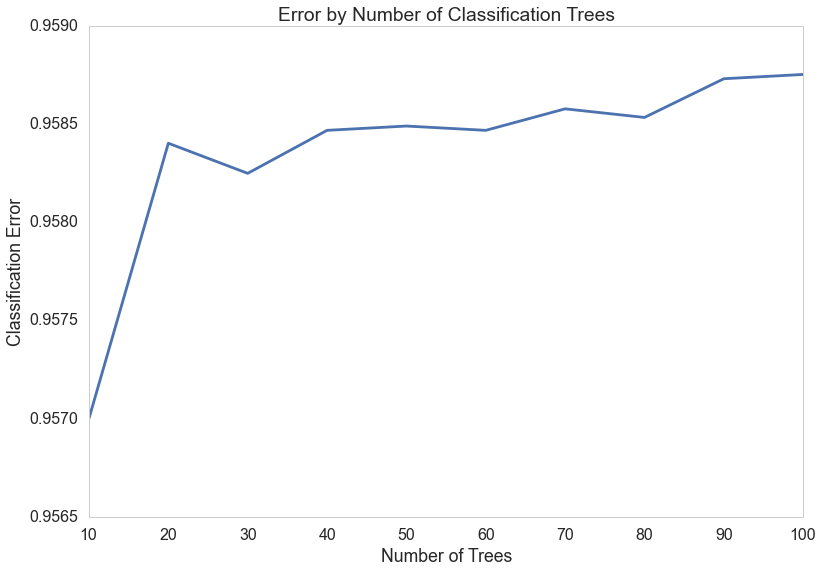

In [121]:
#show plot of error and number of trees in classifier
plt.plot(scores)
plt.xticks(np.arange(10),num_trees)
plt.ylabel('Classification Error')
plt.xlabel('Number of Trees')
plt.title('Error by Number of Classification Trees')
plt.grid('off')
plt.show()

Here is where I see where the optimal number of trees to be built is. So, the more trees you build the better the prediction will be in theory, but if you build 100,000 trees a lot of them will be redundent and it will take FOREVER to train and test. Therefore, this graph shows that after about 20 trees the model's prediction power levels off. I end up using more trees just to be safe and end up using 80 in the next block of code below. This seems to be a good number to optimize the predictive power while not taking forever to create.

In [122]:
#check the score on the test set for overfitting
rf2 = RandomForestClassifier(n_estimators = 90,
                             class_weight = rf2params['class_weight'], 
                             max_depth = rf2params['max_depth'],
                            oob_score = True)
rf2.fit(X,Y)
print rf2.score(X_test,Y_test)
print rf2.score(X,Y)

0.958904409511
0.981918327516


0.1356345545280804

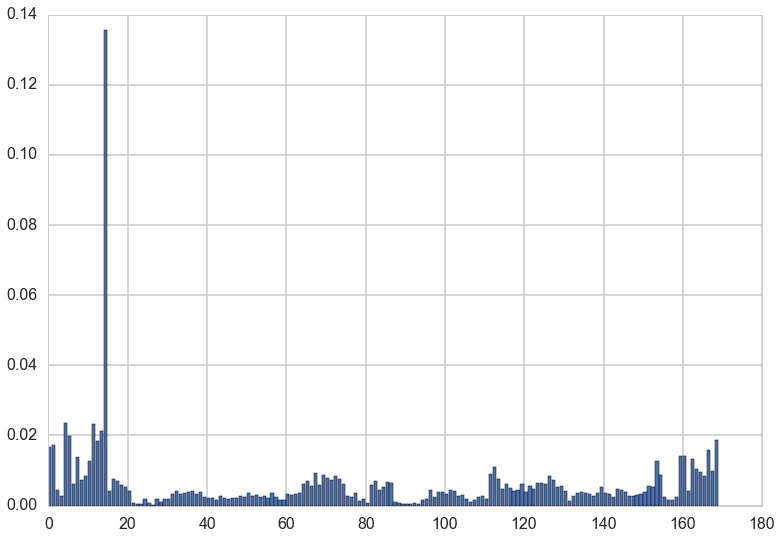

In [123]:
#plot the feature importances
features = rf2.feature_importances_
plt.bar(np.arange(len(features)),features)
max(features)

In [124]:
#Temperature seems to be the best predictor at this point
print features[14]
print fcolumns[14]
print features[len(features)-1]
print fcolumns[len(features)-1]

0.135634554528
temperature
0.0188267492745
weekday=Wednesday


This is the block of code that looks at feature importance. I will have to look more into this. So the higher the bar is on the graph the higher the importance on the split that was used. In order to look more into what each bar is look at the second block of code. Saved in the variable "features" is the actual number of the predictive power. Saved in the variable "fcolumns" is the label for that feature. In the final presentation of the project, this is where we will find the most important features and how we can use them in order to have an output that makes sense. We will add something like the graph above, but obviously more accessable in order to better see the results that we are given. The code above will give us the ability to look into the featuers.

In [125]:
rf2.predict_proba(X_test)

[array([[ 1.        ,  0.        ],
        [ 0.99425737,  0.00574263],
        [ 0.97777778,  0.02222222],
        ..., 
        [ 1.        ,  0.        ],
        [ 1.        ,  0.        ],
        [ 1.        ,  0.        ]]), array([[ 1.        ,  0.        ],
        [ 0.97241249,  0.02758751],
        [ 0.92224494,  0.07775506],
        ..., 
        [ 1.        ,  0.        ],
        [ 1.        ,  0.        ],
        [ 1.        ,  0.        ]]), array([[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        ..., 
        [ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]]), array([[ 0.        ,  1.        ],
        [ 0.03333014,  0.96666986],
        [ 0.09997729,  0.90002271],
        ..., 
        [ 0.        ,  1.        ],
        [ 0.        ,  1.        ],
        [ 0.        ,  1.        ]])]

This is an important thing for Tiner's website "app." So the predict_proba function gives the probability of *each datapoint* of being in each class. So the output is as follows. There are 4 sets of arrays. The first one is the probability that each data point is in "High Surge" with the first number being the prob that it is not high surge, and the second number bing the prob that it is a high surge. The second array is the same thing for Low, then Mid, and finally No surge.

In [126]:
# Fix the Y variable for Logistic Regression
df_final['surge'].head()
Y_lreg = df_final['surge'][mask]
Y_lregtest = df_final['surge'][~mask]
Y_lreg.head()

0    No Surge
1    No Surge
3    No Surge
4    No Surge
7    No Surge
Name: surge, dtype: object

This just creates the Y variable to be passed into Logistic Regression

In [127]:
#parameters to be tested for Logistic Regression
lreg_paramdict = {}
lreg_paramdict['C'] = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lreg_paramdict['penalty'] = ['l1','l2']
lreg_paramdict['multi_class'] = ['ovr']
lreg_paramdict['class_weight'] = ['auto',None]

This are the parameters to be checked for Logistic Regression. Let me just explain this part. It is more complicated with regularization and such. For the write up, I'll just write this part.

In [128]:
# optimize parameters for logistic regression
lreg = LogisticRegression(solver ='lbfgs' )
lreg2, lregparams = cv_optimize(lreg,lreg_paramdict, X, Y_lreg)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0)


In [129]:
lreg2 = LogisticRegression(solver ='lbfgs', C = lregparams['C'], class_weight = lregparams['class_weight'],
                           multi_class = lregparams['multi_class'], penalty = lregparams['penalty'] )
lreg2.fit(X,Y_lreg)
print lreg2.score(X,Y_lreg)
print lreg2.score(X_test,Y_lregtest)

0.959980107345
0.959889652756


Optimize over the Logistic regresssion parameters and see the prediction given. Again i will describe this part.

In [130]:
lreg2.predict_proba(X_test)

array([[ 0.00518183,  0.00625418,  0.00994455,  0.97861945],
       [ 0.01590799,  0.0164415 ,  0.01519367,  0.95245684],
       [ 0.02179111,  0.01923667,  0.01794396,  0.94102827],
       ..., 
       [ 0.01108334,  0.01209312,  0.01232567,  0.96449786],
       [ 0.00875874,  0.00989483,  0.01276466,  0.96858177],
       [ 0.0068804 ,  0.00807891,  0.01009549,  0.9749452 ]])

This is the equvalent to the Random Forest predict_proba, but the output is different. The function outputs an array for each data point and a probability that data point is in each class. As you can see, these probabilities show more of a uncertainty for each class. The first number is probability in High, Low, Mid, then No surge.

In [131]:
lreg2.coef_[3][21]

0.022842776910601381

If we end up using Logistic regression, let me do this and I will deal with more of the analysis of this part.